In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
from autograd import grad
import cca

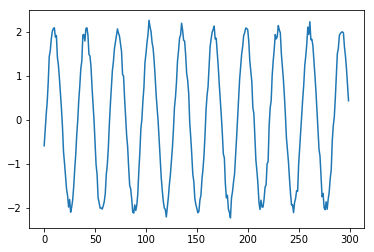

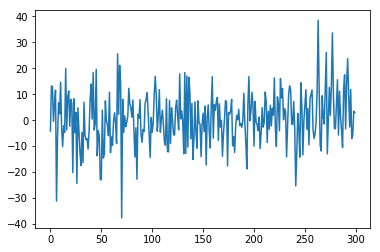

14.238260093079163 0.09209108856848047


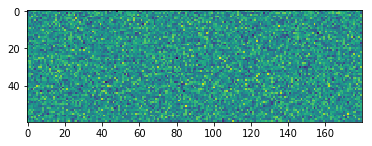

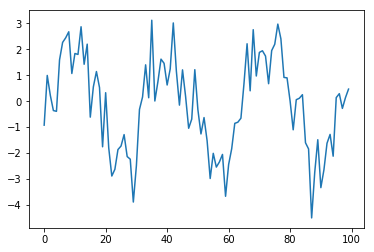

In [6]:
N = 60
len_X = 10000
d = 1
T = 20

E = scipy.stats.ortho_group.rvs(N)[:, :latent_dim]
dynamics = np.zeros((len_X, latent_dim))
t = np.arange(len_X)*0.2
for i in range(latent_dim):
    a, b = np.random.normal(0, 1, (2,))
    dynamics[:, i] = a*np.sin(t) + b*np.cos(t)

dynamics = dynamics + np.random.normal(0, 0.1, dynamics.shape)
noisy_dynamics = dynamics + np.random.normal(0, 10, dynamics.shape)

plt.plot(dynamics[:300,:])
plt.show()

plt.plot(noisy_dynamics[:300,:])
plt.show()

original_pi = cca.calc_pi(dynamics, T)
noisy_pi = cca.calc_pi(noisy_dynamics, T)
print(original_pi, noisy_pi)

X = np.dot(dynamics, E.T)
X = X + np.random.normal(0, 1, X.shape)

plt.imshow(X[:3*N, :].T)
plt.show()

plt.plot(np.dot(X, E[:, :latent_dim])[:100])
plt.show()

4.908257474769426


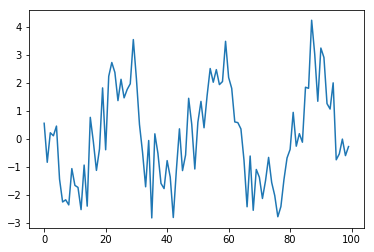

In [7]:
V_opt = cca.run_cca(X, T, latent_dim)
X_proj = np.dot(X, V_opt)

plt.plot(X_proj[:100])

print(cca.calc_pi(X_proj, T))